In [61]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.metrics
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [62]:
#Veri setinin yüklenmesi
dataset = pd.read_csv('BERT.csv' , sep=';',  engine='python', encoding='cp1254') 
dataset.head() 

,Unnamed: 0,Sentence,Sentiment
0,0,Hayatta küçük şeyleri kovalıyor ve yine küçük ...,-1
1,1,Seydiu şimdi iki mevkiyi de kaybetti.,-1
2,2,"Fakat öte yandan, hayatta gelişim sağlayabilme...",0
3,3,Seferler Haziran ayında başlıyor.,0
4,4,Siyasette temiz insanlara ihtiyacımız var.,1


In [63]:
#Veri Temizleme İşlemleri

#küçük harfe çevirme
dataset['Sentence'] = dataset['Sentence'].apply(lambda x: " ".join(x.lower() for x in x.split()))
#noktalama işaretlerini kaldırma
dataset['Sentence'] = dataset['Sentence'].str.replace('[^\w\s]','')
#sayıları ayıklama
dataset['Sentence'] = dataset['Sentence'].str.replace('\d','')
#durak kelimeler
sw = stopwords.words('turkish')
dataset['Sentence'] = dataset['Sentence'].apply(lambda x: " ".join(x for x in x.split() if x not in sw))
# ender(rare) kelimeler
remove = pd.Series(" ".join(dataset["Sentence"]).split()).value_counts()[-1000:]
dataset["Sentence"]=dataset["Sentence"].apply(lambda x: " ".join(i for i in x.split() if i not in remove))

In [65]:
#Veri seti eğitim ve test verileri olmak üzere ayrılır.

X_train, X_test, y_train, y_test = train_test_split(dataset["Sentence"],dataset["Sentiment"], test_size = 0.15, random_state = 42)

print(f"Eğitim Veri Sayısı : {X_train.shape[0]} Test Veri Sayısı : {X_test.shape[0]}") 

Eğitim Veri Sayısı : 4250 Test Veri Sayısı : 751


In [66]:
#Vektörizasyon işlemleri için CountVectorizer kullanılmıştır.
#CountVectorizer, bir metin belgesi koleksiyonunu bir belirteç sayısı matrisine dönüştürür.
#CountVectorizer’de terim farklı dökümanlarda geçse dahi o kelimenin geçtiği miktarı matriste belirtir. 

vectorizer = CountVectorizer() 
vectorizer.fit(X_train)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [67]:
#Eğitim ve test verileri üzerinde CountVectorizer ile vektörizasyon işlemi yapılmıştır.

x_train_count = vectorizer.transform(X_train)
x_test_count = vectorizer.transform(X_test)

In [68]:
#Vektörizasyon işlemleri için kullanılan bir diğer dönüştürücü ise TF-IDF(Terim Frekansı x Ters Belge Frekansı)'dir.
#TF-IDF'nin amacı, bir belgede sık görülen ancak belgeler arasında olmayan sözcükleri vurgulamaktır.
#TF-IDF,bir kelimenin bulunduğu doküman içindeki değerini gösteren istatistiki yöntemle hesaplanan ağırlık faktörüdür.

tf_idf = TfidfVectorizer()
tf_idf.fit(X_train)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [69]:
#Eğitim ve test verileri üzerinde TF-IDF ile vektörizasyon işlemi yapılmıştır.

x_train_tf_idf = tf_idf.transform(X_train)
x_test_tf_idf = tf_idf.transform(X_test)

### **Makine Öğrenmesi** **Modelleri** 

**1 - Naive Bayes**

In [70]:
nb = MultinomialNB()  #NaiveBayes
nb_model = nb.fit(x_train_count,y_train)

y_pred = nb_model.predict(x_test_count) #counvectorizer

#accuracy
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       0.64      0.69      0.67       307
           0       0.71      0.77      0.74       369
           1       0.44      0.11      0.17        75

    accuracy                           0.67       751
   macro avg       0.60      0.52      0.52       751
weighted avg       0.65      0.67      0.65       751



In [71]:
from sklearn.metrics import confusion_matrix #Karmaşıklık matrisi - countvectorizer
import itertools

y_pred = nb.predict(x_test_count)
y_true = y_test

cm = confusion_matrix(y_true, y_pred.round())  

In [72]:
#Karmaşıklık matrisi fonksiyonu
def plot_confusion_matrix(cm, classes,             
                          normalize=False,
                         title="Karmaşıklık Matrisi",
                         cmap = plt.cm.Blues):
    plt.imshow(cm,interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    if normalize:
        cm=cm.astype('float')/ cm.sum(axis=1)[:,np.newaxis]
        print("Normalleştirilmiş Karmaşıklık Matrisi")
    else:
        print("Normalleştirme Olmadan Karmaşıklık Matrisi")
    
    print(cm)
    
    thresh=cm.max()/2.
    
    for i,j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i,j],
                horizontalalignment='center',
                color='white' if cm[i,j]>thresh else 'black')
    plt.tight_layout()
    plt.ylabel("Gerçek Değerler")
    plt.xlabel("Tahmin Edilen Değerler")

Normalleştirme Olmadan Karmaşıklık Matrisi
[[213  87   7]
 [ 83 283   3]
 [ 37  30   8]]


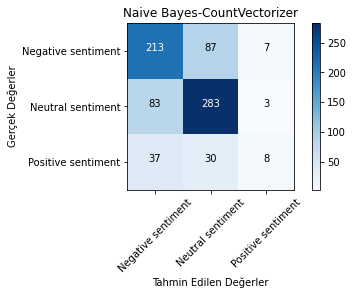

In [73]:
cm_plot_labels=['Negative sentiment','Neutral sentiment','Positive sentiment']
plot_confusion_matrix(cm,cm_plot_labels,title='Naive Bayes-CountVectorizer')

In [74]:
nb_model = nb.fit(x_train_tf_idf,y_train) #Naive Bayes - tf-idf

y_pred = nb_model.predict(x_test_tf_idf)

#accuracy
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       0.64      0.64      0.64       307
           0       0.66      0.80      0.73       369
           1       0.00      0.00      0.00        75

    accuracy                           0.65       751
   macro avg       0.43      0.48      0.46       751
weighted avg       0.59      0.65      0.62       751



Normalleştirme Olmadan Karmaşıklık Matrisi
[[213  87   7]
 [ 83 283   3]
 [ 37  30   8]]


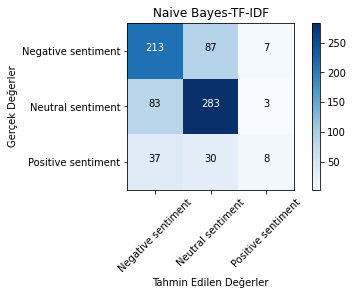

In [75]:
cm_plot_labels=['Negative sentiment','Neutral sentiment','Positive sentiment']
plot_confusion_matrix(cm,cm_plot_labels,title='Naive Bayes-TF-IDF')

**2 - Random Forest**

In [76]:
rf = RandomForestClassifier() #RandomForest-countvectorizer
rf_model = rf.fit(x_train_count,y_train)

y_pred = rf_model.predict(x_test_count)

#accuracy
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       0.67      0.50      0.57       307
           0       0.64      0.85      0.73       369
           1       0.40      0.19      0.25        75

    accuracy                           0.64       751
   macro avg       0.57      0.51      0.52       751
weighted avg       0.63      0.64      0.62       751



In [77]:
from sklearn.metrics import confusion_matrix #Karmaşıklık matrisi - countvectorizer
import itertools

y_pred = rf.predict(x_test_count)
y_true = y_test

cm = confusion_matrix(y_true, y_pred.round())  

Normalleştirme Olmadan Karmaşıklık Matrisi
[[152 137  18]
 [ 52 314   3]
 [ 24  37  14]]


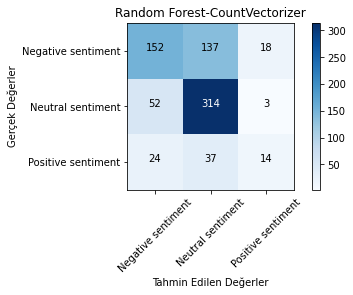

In [78]:
cm_plot_labels=['Negative sentiment','Neutral sentiment','Positive sentiment']
plot_confusion_matrix(cm,cm_plot_labels,title='Random Forest-CountVectorizer')

In [79]:
rf_model = rf.fit(x_train_tf_idf,y_train) #tf-idf

y_pred = rf_model.predict(x_test_tf_idf)

#accuracy
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       0.65      0.54      0.59       307
           0       0.65      0.82      0.73       369
           1       0.45      0.20      0.28        75

    accuracy                           0.64       751
   macro avg       0.59      0.52      0.53       751
weighted avg       0.63      0.64      0.62       751



In [80]:
from sklearn.metrics import confusion_matrix #Karmaşıklık matrisi - tf-idf
import itertools

y_pred = rf.predict(x_test_tf_idf)
y_true = y_test

cm = confusion_matrix(y_true, y_pred.round())  

Normalleştirme Olmadan Karmaşıklık Matrisi
[[165 126  16]
 [ 65 302   2]
 [ 24  36  15]]


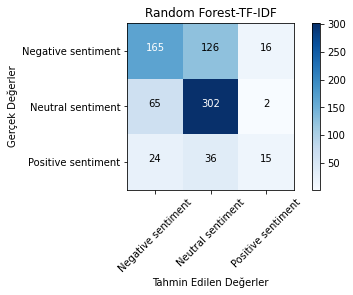

In [81]:
cm_plot_labels=['Negative sentiment','Neutral sentiment','Positive sentiment']
plot_confusion_matrix(cm,cm_plot_labels,title='Random Forest-TF-IDF')

**3 - Support Vector Machine**

In [82]:
svm = LinearSVC() #Support Vector Machine
svm_model = svm.fit(x_train_count,y_train)

y_pred = svm_model.predict(x_test_count) #countvectorizer

#accuracy
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       0.66      0.66      0.66       307
           0       0.70      0.73      0.71       369
           1       0.39      0.31      0.34        75

    accuracy                           0.66       751
   macro avg       0.58      0.56      0.57       751
weighted avg       0.65      0.66      0.65       751



In [83]:
from sklearn.metrics import confusion_matrix #Karmaşıklık matrisi - countvectorizer
import itertools

y_pred = svm.predict(x_test_count)
y_true = y_test

cm = confusion_matrix(y_true, y_pred.round())  

Normalleştirme Olmadan Karmaşıklık Matrisi
[[202  85  20]
 [ 85 268  16]
 [ 20  32  23]]


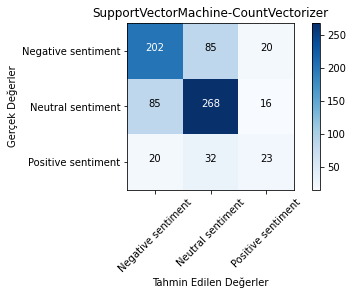

In [84]:
cm_plot_labels=['Negative sentiment','Neutral sentiment','Positive sentiment']
plot_confusion_matrix(cm,cm_plot_labels,title='SupportVectorMachine-CountVectorizer')

In [85]:
svm_model = svm.fit(x_train_tf_idf,y_train) #tf-idf

y_pred = svm_model.predict(x_test_tf_idf)

#accuracy
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       0.67      0.66      0.67       307
           0       0.71      0.75      0.73       369
           1       0.40      0.29      0.34        75

    accuracy                           0.67       751
   macro avg       0.59      0.57      0.58       751
weighted avg       0.66      0.67      0.66       751



In [86]:
from sklearn.metrics import confusion_matrix #Karmaşıklık matrisi - tf-idf
import itertools

y_pred = svm.predict(x_test_tf_idf)
y_true = y_test

cm = confusion_matrix(y_true, y_pred.round())  

Normalleştirme Olmadan Karmaşıklık Matrisi
[[203  84  20]
 [ 78 278  13]
 [ 22  31  22]]


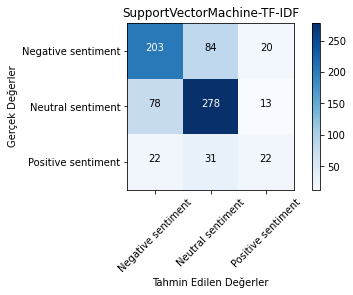

In [87]:
cm_plot_labels=['Negative sentiment','Neutral sentiment','Positive sentiment']
plot_confusion_matrix(cm,cm_plot_labels,title='SupportVectorMachine-TF-IDF')

**4 - Decision Tree**

In [88]:
dt = DecisionTreeClassifier() #Decision Tree
dt_model = dt.fit(x_train_count,y_train)

y_pred = dt_model.predict(x_test_count) #countvectorizer

#accuracy
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       0.59      0.54      0.56       307
           0       0.64      0.74      0.69       369
           1       0.35      0.21      0.26        75

    accuracy                           0.61       751
   macro avg       0.53      0.50      0.51       751
weighted avg       0.59      0.61      0.60       751



In [89]:
from sklearn.metrics import confusion_matrix #Karmaşıklık matrisi - countvectorizer
import itertools

y_pred = dt.predict(x_test_count)
y_true = y_test

cm = confusion_matrix(y_true, y_pred.round())  

Normalleştirme Olmadan Karmaşıklık Matrisi
[[165 121  21]
 [ 86 274   9]
 [ 28  31  16]]


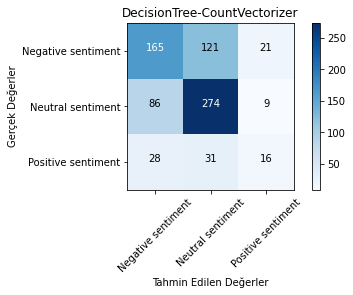

In [90]:
cm_plot_labels=['Negative sentiment','Neutral sentiment','Positive sentiment']
plot_confusion_matrix(cm,cm_plot_labels,title='DecisionTree-CountVectorizer')

In [91]:
dt_model = dt.fit(x_train_tf_idf,y_train) #tf-idf

y_pred = dt_model.predict(x_test_tf_idf)

#accuracy
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       0.56      0.50      0.53       307
           0       0.63      0.71      0.67       369
           1       0.35      0.29      0.32        75

    accuracy                           0.58       751
   macro avg       0.51      0.50      0.51       751
weighted avg       0.57      0.58      0.58       751



In [92]:
from sklearn.metrics import confusion_matrix #Karmaşıklık matrisi - tf-idf
import itertools

y_pred = dt.predict(x_test_tf_idf)
y_true = y_test

cm = confusion_matrix(y_true, y_pred.round())  

Normalleştirme Olmadan Karmaşıklık Matrisi
[[154 125  28]
 [ 95 261  13]
 [ 27  26  22]]


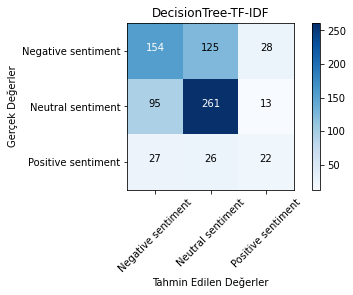

In [93]:
cm_plot_labels=['Negative sentiment','Neutral sentiment','Positive sentiment']
plot_confusion_matrix(cm,cm_plot_labels,title='DecisionTree-TF-IDF')

**5 - KNN**

In [94]:
knn = KNeighborsClassifier() #knn
knn_model = knn.fit(x_train_count,y_train)

y_pred = knn_model.predict(x_test_count) #countvectorizer

#accuracy
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       0.50      0.54      0.52       307
           0       0.58      0.64      0.61       369
           1       0.56      0.07      0.12        75

    accuracy                           0.54       751
   macro avg       0.54      0.42      0.41       751
weighted avg       0.54      0.54      0.52       751



In [95]:
from sklearn.metrics import confusion_matrix #Karmaşıklık matrisi - countvectorizer
import itertools

y_pred = knn.predict(x_test_count)
y_true = y_test

cm = confusion_matrix(y_true, y_pred.round()) 

Normalleştirme Olmadan Karmaşıklık Matrisi
[[165 139   3]
 [131 237   1]
 [ 35  35   5]]


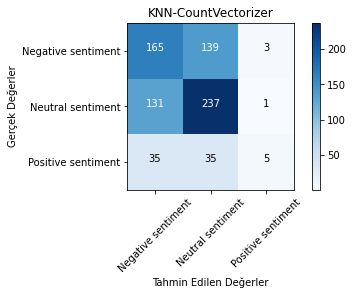

In [96]:
cm_plot_labels=['Negative sentiment','Neutral sentiment','Positive sentiment']
plot_confusion_matrix(cm,cm_plot_labels,title='KNN-CountVectorizer')

In [97]:
knn_model = knn.fit(x_train_tf_idf,y_train) #tf-idf

y_pred = knn_model.predict(x_test_tf_idf)

#accuracy
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          -1       0.63      0.39      0.48       307
           0       0.57      0.86      0.68       369
           1       0.33      0.01      0.03        75

    accuracy                           0.58       751
   macro avg       0.51      0.42      0.40       751
weighted avg       0.57      0.58      0.53       751



In [98]:
from sklearn.metrics import confusion_matrix #Karmaşıklık matrisi - TF-IDF
import itertools

y_pred = knn.predict(x_test_tf_idf)
y_true = y_test

cm = confusion_matrix(y_true, y_pred.round())  

Normalleştirme Olmadan Karmaşıklık Matrisi
[[119 187   1]
 [ 52 316   1]
 [ 18  56   1]]


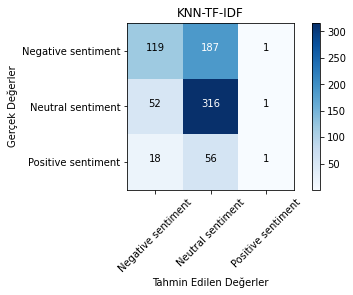

In [99]:
cm_plot_labels=['Negative sentiment','Neutral sentiment','Positive sentiment']
plot_confusion_matrix(cm,cm_plot_labels,title='KNN-TF-IDF')